In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib OK")
print("Scikit-learn OK")

Pandas version: 2.3.3
NumPy version: 2.3.5
Matplotlib OK
Scikit-learn OK


In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)

# ---- CONFIG ----
NUM_SITES = 50
NUM_WEEKS = 52

# Generate base grid
sites = [f"site_{i:03d}" for i in range(1, NUM_SITES + 1)]
weeks = list(range(1, NUM_WEEKS + 1))

rows = []
for site in sites:
    # base pattern for each site
    baseline_incidents = np.random.randint(2, 10)

    for week in weeks:
        hours = np.random.randint(1500, 4500)
        incidents = baseline_incidents + np.random.randint(-2, 3)
        severity = np.random.choice([0, 1], p=[0.92, 0.08])
        overtime = np.random.uniform(0.05, 0.20)
        temperature = np.random.normal(70, 15)
        staffing_ratio = np.random.uniform(0.8, 1.2)
        idle_time = np.random.uniform(0, 60)

        rows.append([
            site, week, hours, incidents, severity,
            overtime, temperature, staffing_ratio, idle_time
        ])

df = pd.DataFrame(rows, columns=[
    "site_id", "week", "hours_worked", "incident_count",
    "severity", "overtime_ratio", "temperature",
    "staffing_ratio", "unexpected_idle_time"
])

df.head()


,site_id,week,hours_worked,incident_count,severity,overtime_ratio,temperature,staffing_ratio,unexpected_idle_time
0,site_001,1,2360,8,0,0.139528,56.247597,0.983700,20.022517
1,site_001,2,4419,8,0,0.195486,68.137792,1.132977,12.740347
2,site_001,3,2715,9,0,0.095636,30.811765,0.916492,36.711174
3,site_001,4,3547,9,1,0.084916,84.255545,0.836243,37.103161
4,site_001,5,3399,9,0,0.056968,52.735096,0.826021,56.933132


In [3]:
import random

df_anom = df.copy()

# ---- 1. INCIDENT SPIKES ----
for _ in range(60):
    idx = random.randint(0, len(df_anom) - 1)
    df_anom.loc[idx, "incident_count"] *= random.randint(3, 7)

# ---- 2. ZERO INCIDENT WEEKS (should be rare) ----
zero_indices = np.random.choice(df_anom.index, size=40, replace=False)
df_anom.loc[zero_indices, "incident_count"] = 0

# ---- 3. HIGH OVERTIME RATIO ----
high_ot_idx = np.random.choice(df_anom.index, size=30, replace=False)
df_anom.loc[high_ot_idx, "overtime_ratio"] = np.random.uniform(0.35, 0.60, size=30)

# ---- 4. STAFFING RATIO CRASH ----
low_staff_idx = np.random.choice(df_anom.index, size=30, replace=False)
df_anom.loc[low_staff_idx, "staffing_ratio"] = np.random.uniform(0.40, 0.70, size=30)

# ---- 5. EXTREME TEMPERATURES ----
temp_idx = np.random.choice(df_anom.index, size=25, replace=False)
df_anom.loc[temp_idx, "temperature"] = np.random.uniform(-20, 140, size=25)

# ---- 6. OUTLIER IDLE TIME ----
idle_idx = np.random.choice(df_anom.index, size=25, replace=False)
df_anom.loc[idle_idx, "unexpected_idle_time"] = np.random.uniform(120, 400, size=25)

df_anom.head(10)

,site_id,week,hours_worked,incident_count,severity,overtime_ratio,temperature,staffing_ratio,unexpected_idle_time
0,site_001,1,2360,8,0,0.139528,56.247597,0.983700,20.022517
1,site_001,2,4419,8,0,0.195486,68.137792,1.132977,12.740347
2,site_001,3,2715,9,0,0.095636,30.811765,0.916492,36.711174
3,site_001,4,3547,9,1,0.084916,84.255545,0.836243,37.103161
4,site_001,5,3399,9,0,0.056968,52.735096,0.826021,383.139225
5,site_001,6,3863,7,0,0.052395,75.635470,0.892358,14.461528
6,site_001,7,2978,9,0,0.055158,66.558243,1.065009,18.702665
7,site_001,8,4113,7,0,0.054697,75.840234,1.136914,26.985248
8,site_001,9,1701,9,0,0.188281,68.265276,0.955471,16.280942
9,site_001,10,2576,7,1,0.141055,65.483445,0.910400,17.776410


In [4]:
df_anom.describe()


,week,hours_worked,incident_count,severity,overtime_ratio,temperature,staffing_ratio,unexpected_idle_time
count,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000
mean,26.500000,2976.249615,6.257308,0.073077,0.129634,69.798378,0.991461,32.113251
std,15.011218,875.413653,4.845868,0.260313,0.058509,15.889660,0.124643,27.858621
min,1.000000,1500.000000,0.000000,0.000000,0.050036,-18.556071,0.406081,0.065221
25%,13.750000,2211.750000,4.000000,0.000000,0.087887,59.790604,0.894502,15.544396
50%,26.500000,2971.500000,6.000000,0.000000,0.126795,69.882155,0.992762,30.622977
75%,39.250000,3717.750000,8.000000,0.000000,0.164545,80.404320,1.092211,45.170909
max,52.000000,4496.000000,77.000000,1.000000,0.593155,136.547104,1.199970,399.834965


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Select numeric features for modeling
features = [
    "hours_worked",
    "incident_count",
    "severity",
    "overtime_ratio",
    "temperature",
    "staffing_ratio",
    "unexpected_idle_time"
]

X = df_anom[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination=0.10,   # expect ~10% anomalies
    random_state=42
)

iso.fit(X_scaled)

# Predict anomalies
df_anom["anomaly_score"] = iso.decision_function(X_scaled)
df_anom["is_anomaly"] = iso.predict(X_scaled)

# Convert to 1 = anomaly, 0 = normal
df_anom["is_anomaly"] = df_anom["is_anomaly"].map({1: 0, -1: 1})

df_anom.head()


,site_id,week,hours_worked,incident_count,severity,overtime_ratio,temperature,staffing_ratio,unexpected_idle_time,anomaly_score,is_anomaly
0,site_001,1,2360,8,0,0.139528,56.247597,0.983700,20.022517,0.131674,0
1,site_001,2,4419,8,0,0.195486,68.137792,1.132977,12.740347,0.063790,0
2,site_001,3,2715,9,0,0.095636,30.811765,0.916492,36.711174,0.072589,0
3,site_001,4,3547,9,1,0.084916,84.255545,0.836243,37.103161,-0.031306,1
4,site_001,5,3399,9,0,0.056968,52.735096,0.826021,383.139225,-0.072649,1


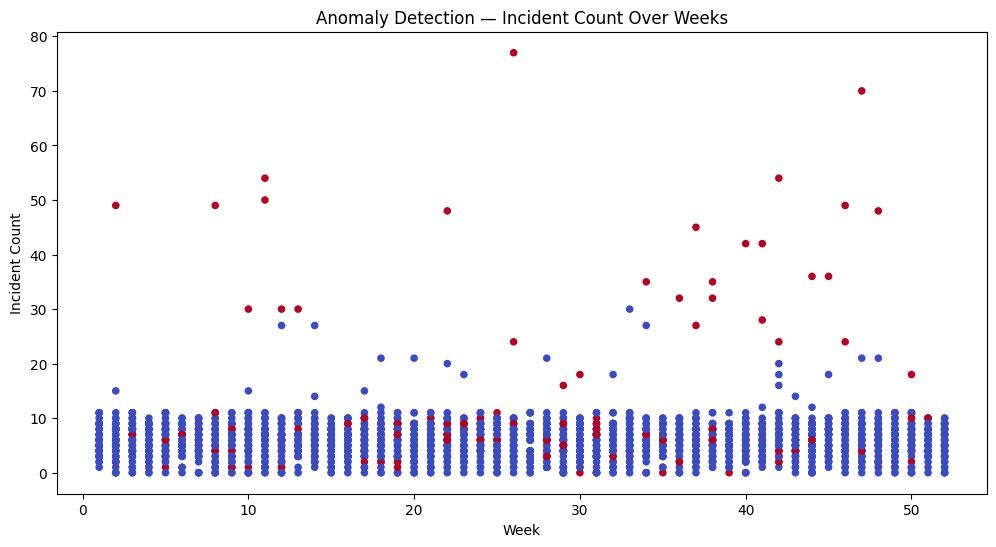

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.scatter(df_anom["week"], df_anom["incident_count"], 
            c=df_anom["is_anomaly"], cmap="coolwarm", s=20)
plt.title("Anomaly Detection — Incident Count Over Weeks")
plt.xlabel("Week")
plt.ylabel("Incident Count")
plt.show()


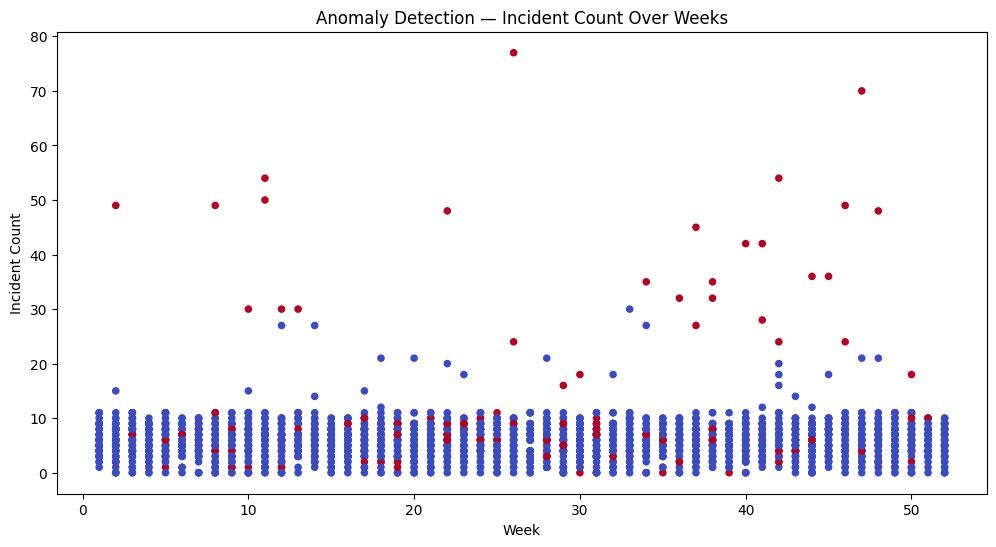

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(df_anom["week"], df_anom["incident_count"], 
            c=df_anom["is_anomaly"], cmap="coolwarm", s=20)
plt.title("Anomaly Detection — Incident Count Over Weeks")
plt.xlabel("Week")
plt.ylabel("Incident Count")
plt.savefig("../visuals/incident_anomalies.png", dpi=300, bbox_inches="tight")
plt.show()


In [8]:
df_anom.to_csv("../data/anomaly_output.csv", index=False)
